In [1]:
# !wget https://raw.githubusercontent.com/huseinzol05/project-suka-suka/main/mysejahtera-density/data/Kedah-points.json-points-cases.json
# https://pysal.org/esda/notebooks/adbscan_berlin_example.html

In [2]:
import json
import pandas as pd
import geopandas
from shapely.geometry import Point
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import contextily as cx

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
import warnings
import pandas
import numpy as np
from libpysal.cg.alpha_shapes import alpha_shape_auto
from scipy.spatial import cKDTree
from collections import Counter
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator as _BaseEstimator, ClusterMixin as _ClusterMixin

In [4]:
with open('Kedah-points.json-points-cases.json') as fopen:
    data = json.load(fopen)
    
df = pd.DataFrame(data)
df.head()

,0,1,2
0,5.088469,100.531476,0
1,5.084469,100.547476,0
2,5.080469,100.551476,0
3,5.080469,100.555476,0
4,5.084469,100.555476,0


In [5]:
nonzero = df[2][df[2] > 0]
step = 0.05
arange = np.arange(0, 1.0 + step, step = step)
percentiles = np.percentile(nonzero, arange * 100)
percentiles

array([  1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,   1.  ,
         1.  ,   2.  ,   2.  ,   3.  ,   3.  ,   4.  ,   4.  ,   5.  ,
         7.  ,   9.  ,  12.  ,  20.85, 167.  ])

In [6]:
boundaries = [percentiles[i: i + 2].tolist() for i in range(len(percentiles))][:-1]
boundaries = [[int(i[0]), int(i[1])] for i in boundaries]
boundaries[-1][-1] += 1
boundaries

[[1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 2],
 [2, 2],
 [2, 3],
 [3, 3],
 [3, 4],
 [4, 4],
 [4, 5],
 [5, 7],
 [7, 9],
 [9, 12],
 [12, 20],
 [20, 168]]

/home/ubuntu/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


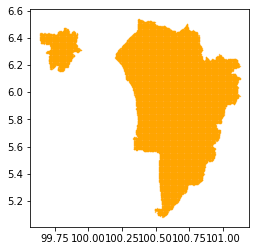

In [7]:
geometry = [Point(xy) for xy in zip(df[0], df[1])]
crs = {'init': 'epsg:4326'}
bl_gdf = GeoDataFrame(df, crs=crs, geometry=geopandas.points_from_xy(df[1], df[0]))
db = bl_gdf.to_crs(epsg=5243)
db.to_crs('crs').plot(markersize=0.1, color='orange')
db["X"] = db.geometry.x
db["Y"] = db.geometry.y

In [8]:
from libpysal.cg.alpha_shapes import alpha_shape_auto

def get_cluster_boundary(labels, xys, scores, xy=["X", "Y"], crs=None, step=1):
    try:
        from geopandas import GeoSeries
    except ModuleNotFoundError:

        def GeoSeries(data, index=None, crs=None):
            return list(data)

    lbl_type = type(labels.iloc[0])
    noise = lbl_type(-1)
    ids_in_cluster = labels[labels != noise].index
    g = xys.loc[ids_in_cluster, xy].groupby(labels[ids_in_cluster])
    polys = []
    cluster_lbls = []
    y, totals = [], []
    for sub in g.groups:
        try:
            polys.append(_asa((xys.loc[g.groups[sub], xy].values, 1)))
            y.append(scores.loc[g.groups[sub]].mean())
            totals.append(scores.loc[g.groups[sub]].shape[0])
            cluster_lbls.append(sub)
        except:
            pass
    polys = GeoSeries(polys, index=cluster_lbls, crs=crs)
    return polys, y, totals


def _asa(pts_s):
    return alpha_shape_auto(pts_s[0], step=pts_s[1])

In [9]:
from sklearn.cluster import DBSCAN

results = {}
color = {0: '#0000FF', 1: '#0000FF', 2: '#0000FF', 3: '#0000FF',
         4: '#0000FF', 5: '#0000FF', 6: '#0000FF', 7: '#FFFF00',
         8: '#FFFF00', 9: '#FFFF00', 10: '#FFFF00', 11: '#FFFF00',
         12: '#FFFF00', 13: '#FF0000', 14: '#FF0000', 15: '#FF0000',
         16: '#FF0000', 17: '#FF0000', 18: '#FF0000', 19: '#FF0000'}

already_processed = set()
for i in range(len(boundaries)):
    print(i, boundaries[i])
    
    if (boundaries[i][1] - boundaries[i][0]) < 1:
        continue
        
    if str(boundaries[i]) in already_processed:
        continue
        
    dbscan = DBSCAN(eps=0.005, min_samples=3)
    filtered_df = df[(df[2] >= boundaries[i][0]) & (df[2] < boundaries[i][1])]
    filtered_df_index = filtered_df.index
    clustering = dbscan.fit(filtered_df[[0,1]].values)

    labels = np.full(shape=df.shape[0], fill_value=-1)
    for no in range(len(clustering.labels_)):
        labels[filtered_df_index[no]] = clustering.labels_[no]
        
    print(np.unique(labels))
    
    polys, ys, totals = get_cluster_boundary(pd.Series(labels), db, db[2], crs=db.crs)
    polys = polys.to_crs('crs')

    polygons = []
    for k in range(len(polys)):
        polygons_ = []
        x, y = polys.iloc[k].exterior.coords.xy
        for x_, y_ in zip(x, y):
            polygons_.append({'lat': y_, 'lng': x_})
        polygons.append(polygons_)

    results[i] = {'polygons': polygons, 'data': [ys, totals], 'color': color[i]}
    already_processed.add(str(boundaries))

0 [1, 1]
1 [1, 1]
2 [1, 1]
3 [1, 1]
4 [1, 1]
5 [1, 1]
6 [1, 1]
7 [1, 1]
8 [1, 2]
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


9 [2, 2]
10 [2, 3]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:628: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = (1 / radi) - EPS


11 [3, 3]
12 [3, 4]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


13 [4, 4]
14 [4, 5]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


15 [5, 7]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


16 [7, 9]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


17 [9, 12]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)


18 [12, 20]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


19 [20, 168]
[-1  0  1  2  3  4  5  6  7  8  9 10]


/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:574: UserWarning: Numba not imported, so alpha shape construction may be slower than expected.
  warn(NUMBA_WARN)
/home/ubuntu/.local/lib/python3.7/site-packages/libpysal/cg/alpha_shapes.py:117: RuntimeWarning: invalid value encountered in sqrt
  den = np.sqrt((ab + bc + ca) * (bc + ca - ab) * (ca + ab - bc) * (ab + bc - ca))


In [10]:
results.keys()

dict_keys([8, 10, 12, 14, 15, 16, 17, 18, 19])

In [11]:
with open('data/kedah.json', 'w') as fopen:
    json.dump(results, fopen)